## Урок 2

### Задача 1

Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке).

<font color = 'blue'> См. код ниже.

### Задача 2

Повторить п.2, но используя уже не медиану, а max

<font color = 'blue'> См. код ниже.

### Задача 3

(опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

<font color = 'blue'> Пока не сделала.

In [1]:
import pandas as pd

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [5]:
from gensim.corpora.dictionary import Dictionary

In [14]:
import re
import numpy as np
from nltk.corpus import stopwords
from razdel import tokenize
import pymorphy2

In [16]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [17]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [18]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [19]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-18-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 37.1 s


In [20]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 6min 50s


In [21]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [22]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [23]:
common_dictionary[10]

'ватутин'

In [26]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 1min 34s


In [27]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [28]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(6, 0.19851062), (7, 0.6977636), (11, 0.08400785)]

In [29]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: задержать эксперимент источник сотрудник полицейский особенность полиция
topic_1: фонд медведев реактор привычный козак благотворительный красноярский
topic_2: армения индонезия армянский казахстанский луценко жирный бин
topic_3: взрыв ставка ресурс теория констатировать атмосферный кольцо
topic_4: украина украинский киев превысить украинец акционер пётр
topic_5: товар конкурс супруг мальчик юг сократиться великобритания
topic_6: это который мочь человек сша свой россия
topic_7: год это который человек nn свой стать
topic_8: год это рубль исследование рост цена рынок
topic_9: статья пациент лечение ст сестра музыка предъявить
topic_10: министерство мышь прогнозировать перевод грузия латвия братский
topic_11: nn век остров год станция дональд министерство
topic_12: гражданин болезнь проверка километр врач фронт фотография
topic_13: год военный газ россия американский компания российский
topic_14: район технология область температура авария компания пострадать
topic_15: ракета з

In [30]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [31]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.042402,0.0,0.0,0.00000,0.015063,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.650033,0.0,0.174574
1,4896,0.0,0.0,0.0,0.921142,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.055848,0.0,0.000000,0.0,0.000000
2,4897,0.0,0.0,0.0,0.000000,0.0,0.0,0.19854,0.697839,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,4898,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.840298,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.148709
4,4899,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.581076,0.0,0.000000,0.0,0.322961,0.0,0.000000


In [32]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [33]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [34]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.12786894, 0.29449663, 0.        , 0.        ,
       0.        , 0.13044968, 0.        , 0.        , 0.        ,
       0.02021893, 0.03775201, 0.        , 0.10208435, 0.        ,
       0.11089388, 0.04409318, 0.        , 0.        , 0.12242378])

In [35]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [50]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [64]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [36]:
get_user_embedding(user_articles_list)

array([0.02517833, 0.        , 0.        , 0.        , 0.0040241 ,
       0.        , 0.24806763, 0.06775094, 0.0647327 , 0.        ,
       0.        , 0.        , 0.00843373, 0.09287634, 0.01016093,
       0.00167847, 0.        , 0.011398  , 0.17346209, 0.01807824,
       0.11279159, 0.        , 0.        , 0.01122259, 0.13405721])

In [51]:
get_user_embedding_median(user_articles_list)

array([0.00853702, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.22776471, 0.02416618, 0.0087697 , 0.        ,
       0.        , 0.        , 0.        , 0.0353439 , 0.        ,
       0.        , 0.        , 0.        , 0.12968944, 0.        ,
       0.        , 0.        , 0.        , 0.0064426 , 0.12347212])

In [65]:
get_user_embedding_max(user_articles_list)

array([0.09008028, 0.        , 0.        , 0.        , 0.02414462,
       0.        , 0.61117351, 0.20965934, 0.22661452, 0.        ,
       0.        , 0.        , 0.02904619, 0.3491379 , 0.06096559,
       0.0100708 , 0.        , 0.04969674, 0.49854246, 0.07957018,
       0.63121641, 0.        , 0.        , 0.03455358, 0.31143755])

In [37]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.0,0.0,0.004816,0.041477,0.008549,0.099365,0.185516,0.062321,...,0.018028,0.006292,0.000000,0.107520,0.005763,0.070911,0.01729,0.002747,0.000000,0.135375
1,u108690,0.002541,0.0,0.0,0.000000,0.048172,0.009792,0.293918,0.108318,0.061986,...,0.000000,0.000000,0.000000,0.161468,0.017698,0.101550,0.00000,0.000000,0.000000,0.106247
2,u108339,0.009869,0.0,0.0,0.008856,0.000000,0.001974,0.188121,0.070920,0.022986,...,0.000000,0.006090,0.007897,0.088578,0.011419,0.160904,0.00000,0.009339,0.005321,0.181129


In [52]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.0,0.0,0.0,0.000000,0.0,0.063934,0.141099,0.000000,...,0.0,0.0,0.0,0.110440,0.000000,0.055447,0.0,0.0,0.0,0.061212
1,u108690,0.0,0.0,0.0,0.0,0.017338,0.0,0.284494,0.086765,0.000000,...,0.0,0.0,0.0,0.104134,0.007939,0.055684,0.0,0.0,0.0,0.116693
2,u108339,0.0,0.0,0.0,0.0,0.000000,0.0,0.202563,0.047849,0.011006,...,0.0,0.0,0.0,0.068741,0.013891,0.159350,0.0,0.0,0.0,0.174540


In [67]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.0,0.0,0.028897,0.248860,0.051296,0.249566,0.422918,0.285520,...,0.087948,0.037752,0.000000,0.277223,0.034576,0.168516,0.05965,0.016484,0.000000,0.374463
1,u108690,0.015248,0.0,0.0,0.000000,0.171352,0.043219,0.463927,0.277971,0.199573,...,0.000000,0.000000,0.000000,0.465611,0.049920,0.395589,0.00000,0.000000,0.000000,0.176260
2,u108339,0.059216,0.0,0.0,0.037863,0.000000,0.011844,0.295112,0.265079,0.087465,...,0.000000,0.021192,0.030415,0.243290,0.023689,0.310272,0.00000,0.056036,0.031926,0.301610


In [38]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [54]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.0,0.0,0.004816,0.041477,0.008549,0.099365,0.185516,0.062321,...,0.006292,0.000000,0.107520,0.005763,0.070911,0.01729,0.002747,0.000000,0.135375,0
1,u108690,0.002541,0.0,0.0,0.000000,0.048172,0.009792,0.293918,0.108318,0.061986,...,0.000000,0.000000,0.161468,0.017698,0.101550,0.00000,0.000000,0.000000,0.106247,1
2,u108339,0.009869,0.0,0.0,0.008856,0.000000,0.001974,0.188121,0.070920,0.022986,...,0.006090,0.007897,0.088578,0.011419,0.160904,0.00000,0.009339,0.005321,0.181129,1


In [55]:
X_median = pd.merge(user_embeddings_median, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.0,0.0,0.0,0.000000,0.0,0.063934,0.141099,0.000000,...,0.0,0.0,0.110440,0.000000,0.055447,0.0,0.0,0.0,0.061212,0
1,u108690,0.0,0.0,0.0,0.0,0.017338,0.0,0.284494,0.086765,0.000000,...,0.0,0.0,0.104134,0.007939,0.055684,0.0,0.0,0.0,0.116693,1
2,u108339,0.0,0.0,0.0,0.0,0.000000,0.0,0.202563,0.047849,0.011006,...,0.0,0.0,0.068741,0.013891,0.159350,0.0,0.0,0.0,0.174540,1


In [68]:
X_max = pd.merge(user_embeddings_max, target, 'left')
X_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.0,0.0,0.028897,0.248860,0.051296,0.249566,0.422918,0.285520,...,0.037752,0.000000,0.277223,0.034576,0.168516,0.05965,0.016484,0.000000,0.374463,0
1,u108690,0.015248,0.0,0.0,0.000000,0.171352,0.043219,0.463927,0.277971,0.199573,...,0.000000,0.000000,0.465611,0.049920,0.395589,0.00000,0.000000,0.000000,0.176260,1
2,u108339,0.059216,0.0,0.0,0.037863,0.000000,0.011844,0.295112,0.265079,0.087465,...,0.021192,0.030415,0.243290,0.023689,0.310272,0.00000,0.056036,0.031926,0.301610,1


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [56]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [57]:
#разделим данные на train/test
X_train_median, X_test_median, y_train_median, y_test_median = train_test_split(X_median[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_median['churn'], random_state=0)

In [69]:
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X_max[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_max['churn'], random_state=0)

In [58]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [59]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train_median, y_train_median)

LogisticRegression()

In [70]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train_max, y_train_max)

LogisticRegression()

In [43]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.12418586, 0.06800906, 0.57227361, 0.17319265, 0.06653885,
       0.04636682, 0.16739526, 0.17421085, 0.14229107, 0.23958332])

In [60]:
#наши прогнозы для тестовой выборки
preds_median = logreg.predict_proba(X_test_median)[:, 1]
preds_median[:10]

array([0.12030892, 0.05786396, 0.71880087, 0.50251779, 0.08290427,
       0.02272221, 0.13790407, 0.1147317 , 0.19022859, 0.24672715])

In [71]:
#наши прогнозы для тестовой выборки
preds_max = logreg.predict_proba(X_test_max)[:, 1]
preds_max[:10]

array([7.39179097e-02, 2.21683854e-03, 7.75471089e-01, 7.94407121e-02,
       2.35413168e-02, 7.60349422e-04, 2.41939117e-02, 3.33799212e-01,
       3.07427917e-01, 3.39000255e-01])

In [44]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [45]:
import itertools

In [117]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
print(ix)

Best Threshold=0.339039, F-Score=0.668, Precision=0.747, Recall=0.604
877


In [115]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_test_median, preds_median)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix_median = np.argmax(fscore_median)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median[ix_median], 
                                                                        fscore_median[ix_median],
                                                                        precision_median[ix_median],
                                                                        recall_median[ix_median]))
print(ix_median)

Best Threshold=0.260556, F-Score=0.701, Precision=0.640, Recall=0.776
870


In [118]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_test_max, preds_max)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix_max = np.argmax(fscore_max)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_max[ix_max], 
                                                                        fscore_max[ix_max],
                                                                        precision_max[ix_max],
                                                                        recall_max[ix_max]))
print(ix_max)

Best Threshold=0.355665, F-Score=0.747, Precision=0.752, Recall=0.743
739


In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1705   50]
 [  98  147]]


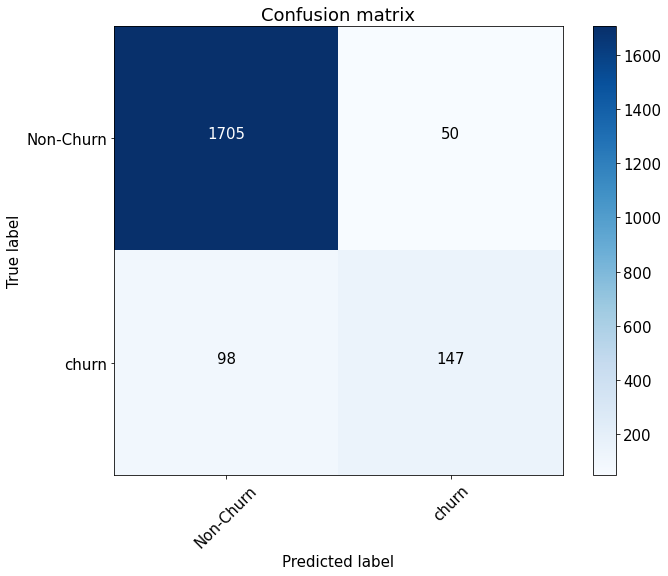

In [48]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[1648  107]
 [  56  189]]


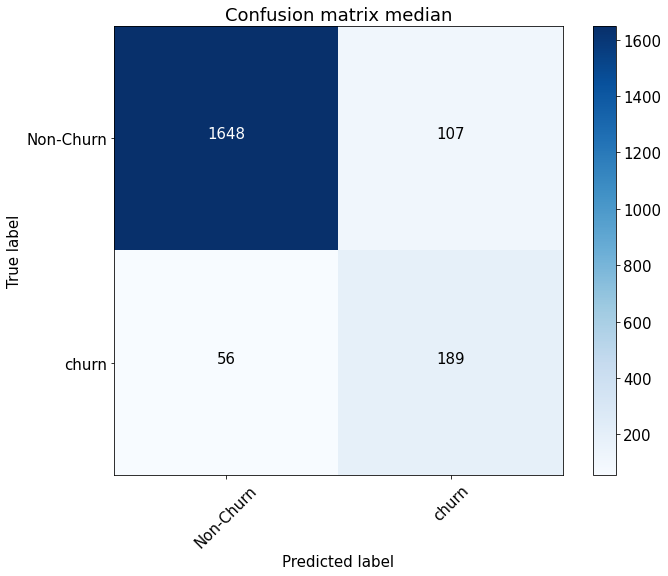

In [119]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_median = confusion_matrix(y_test_median, preds_median>thresholds_median[ix_median])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_median, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix median')
plt.savefig("conf_matrix_median.png")
plt.show()

Confusion matrix, without normalization
[[1695   60]
 [  64  181]]


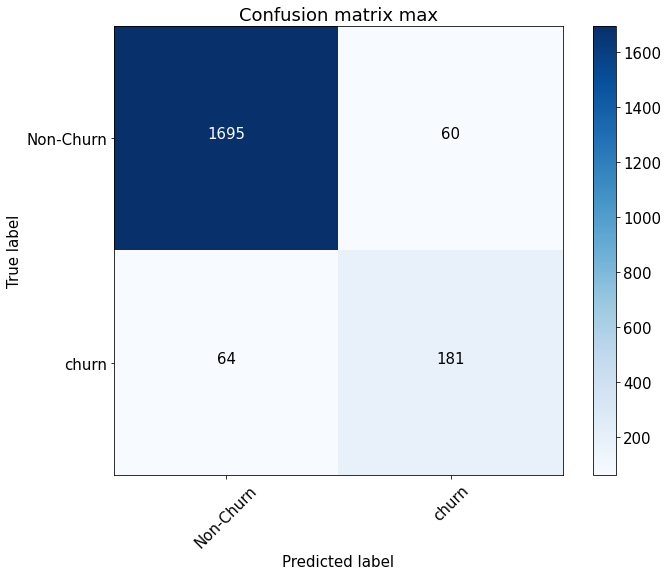

In [120]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_max = confusion_matrix(y_test_max, preds_max>thresholds_max[ix_max])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_max, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix max')
plt.savefig("conf_matrix_max.png")
plt.show()

In [121]:
metrics = [] 

In [122]:
metrics.append([roc_auc_score(y_test, preds), precision[ix], recall[ix], thresholds[ix], fscore[ix]])
metrics

[[0.944147915576487,
  0.7474747474747475,
  0.6040816326530613,
  0.3390389324770861,
  0.6681715575620768]]

In [123]:
metrics.append([roc_auc_score(y_test_median, preds_median), precision[ix_median], recall[ix_median], thresholds[ix_median], fscore[ix_median]])
metrics[1]

[0.9538949938949939,
 0.7317073170731707,
 0.6122448979591837,
 0.33432827628128003,
 0.6666666666666666]

In [124]:
metrics.append([roc_auc_score(y_test_max, preds_max), precision[ix_max], recall[ix_max], thresholds[ix_max], fscore[ix_max]])
metrics[2]

[0.960874469445898,
 0.5595238095238095,
 0.7673469387755102,
 0.2397172414248822,
 0.6471600688468158]

In [125]:
names_list = ['mean', 'median', 'max']

### Задача 4

Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score.

In [126]:
df = pd.DataFrame(metrics, index = names_list, columns =['roc_auc_score', 'precision', 'recall', 'thresholds', 'fscore'])

In [127]:
df.head()

,roc_auc_score,precision,recall,thresholds,fscore
mean,0.944148,0.747475,0.604082,0.339039,0.668172
median,0.953895,0.731707,0.612245,0.334328,0.666667
max,0.960874,0.559524,0.767347,0.239717,0.647160


### Задача  5

Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных.